In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [40]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer,AutoModel
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
df=pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json",lines=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(['article_link'],inplace=True,axis=1)

print(df.shape)
print(df.head()) 

(26708, 2)
                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0


In [42]:
X_train,X_test,y_train,y_test=train_test_split(df['headline'],df['is_sarcastic'],test_size=0.3)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5)

print(X_train.shape,X_test.shape,X_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(18695,) (4007,) (4006,)
(18695,) (4007,) (4006,)


In [43]:
tokenizer=AutoTokenizer.from_pretrained("google-bert/bert-base-uncased") 
bert_model=AutoModel.from_pretrained('google-bert/bert-base-uncased')

In [44]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.x=[tokenizer(x,max_length=100,truncation=True,padding='max_length',return_tensors='pt').to(device) for x in X]

        self.y = torch.tensor(Y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
        

In [45]:
train_dataset=dataset(X_train,y_train)
test_dataset=dataset(X_test,y_test)
val_dataset=dataset(X_val,y_val)


In [46]:
BATCH_SIZE=16
LR=1e-4
EPOCHS=15

In [47]:
train_dataloader=DataLoader(train_dataset,BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(test_dataset,BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_dataset,BATCH_SIZE,shuffle=True)


In [48]:
class Mymodel(nn.Module):
    def __init__(self,bert):
        super().__init__()
        self.bert=bert
        self.dropout=nn.Dropout(0.25)
        self.l1=nn.Linear(768,384)
        self.l2=nn.Linear(384,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self,input_ids,attention_mask):
        pooled_output=self.bert(input_ids,attention_mask,return_dict=False)[0][:,0]
        output=self.l1(pooled_output)
        output=self.dropout(output)
        output=self.l2(output)
        output=self.dropout(output)
        output=self.sigmoid(output)
        return output

In [49]:
for param in bert_model.parameters():
    param.requires_grad=False
model=Mymodel(bert_model)
model.to(device)

Mymodel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [50]:
criterion=nn.BCELoss()
optimizer=Adam(model.parameters(),lr=LR)

In [51]:
total_loss_train_plot=[]
total_loss_val_plot=[]

total_acc_train_plot=[]
total_acc_val_plot=[]

import time

st_time=time.time()

for epoch in range(EPOCHS):
    total_acc_train=0
    total_acc_val=0
    total_loss_val=0
    total_loss_train=0
    for idx,data in enumerate(train_dataloader):
        inputs,labels=data
        inputs.to(device)
        labels.to(device)
        outputs=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
        loss=criterion(outputs,labels)
        total_loss_train+=loss.item()
        acc=(outputs.round()==labels).sum().item()
        total_acc_train+=acc
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for idx,data in enumerate(val_dataloader):
            inputs,labels=data
            inputs.to(device)
            labels.to(device)
            
            outputs=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
            loss=criterion(outputs,labels)
            total_loss_val+=loss.item()
            acc=(outputs.round()==labels).sum().item()
            total_acc_val+=acc
        
    total_loss_train_plot.append(round(total_loss_train/len(train_dataset),4))
    total_loss_val_plot.append(round(total_loss_val/len(val_dataset),4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset),4))
    total_acc_val_plot.append(round(total_acc_val/len(val_dataset),4))

    
    print(f"Epochs {epoch+1} Training loss   {round(total_loss_train/len(train_dataset),4)} Training Accuracy {round(total_acc_train/len(train_dataset),4)}")
    
    print(f"Epochs {epoch+1} Validation loss {round(total_loss_val/len(val_dataset),4)} Validation Accuracy {round(total_acc_val/len(val_dataset),4)}")
        
    print('*'*80)

print("Traning time",round(time.time()-st_time,4))

Epochs 1 Training loss   0.0309 Training Accuracy 0.7468
Epochs 1 Validation loss 0.0284 Validation Accuracy 0.7673
********************************************************************************
Epochs 2 Training loss   0.0275 Training Accuracy 0.7737
Epochs 2 Validation loss 0.0276 Validation Accuracy 0.7773
********************************************************************************
Epochs 3 Training loss   0.0268 Training Accuracy 0.7784
Epochs 3 Validation loss 0.0278 Validation Accuracy 0.7781
********************************************************************************
Epochs 4 Training loss   0.0261 Training Accuracy 0.7872
Epochs 4 Validation loss 0.026 Validation Accuracy 0.7843
********************************************************************************
Epochs 5 Training loss   0.026 Training Accuracy 0.7869
Epochs 5 Validation loss 0.0268 Validation Accuracy 0.7751
********************************************************************************
Epochs 6 Training

In [52]:
with torch.no_grad():
            total_acc_test=0
            total_loss_test=0
            for idx,data in enumerate(test_dataloader):
                
                inputs,labels=data
                inputs.to(device)
                labels.to(device)
                
                outputs=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
                loss=criterion(outputs,labels)
                total_loss_test+=loss.item()
                acc=(outputs.round()==labels).sum().item()
                total_acc_test+=acc

print(f"ACCURACY SCORE IS {round(total_acc_test/len(test_dataset)*100,4)}")


ACCURACY SCORE IS 78.263


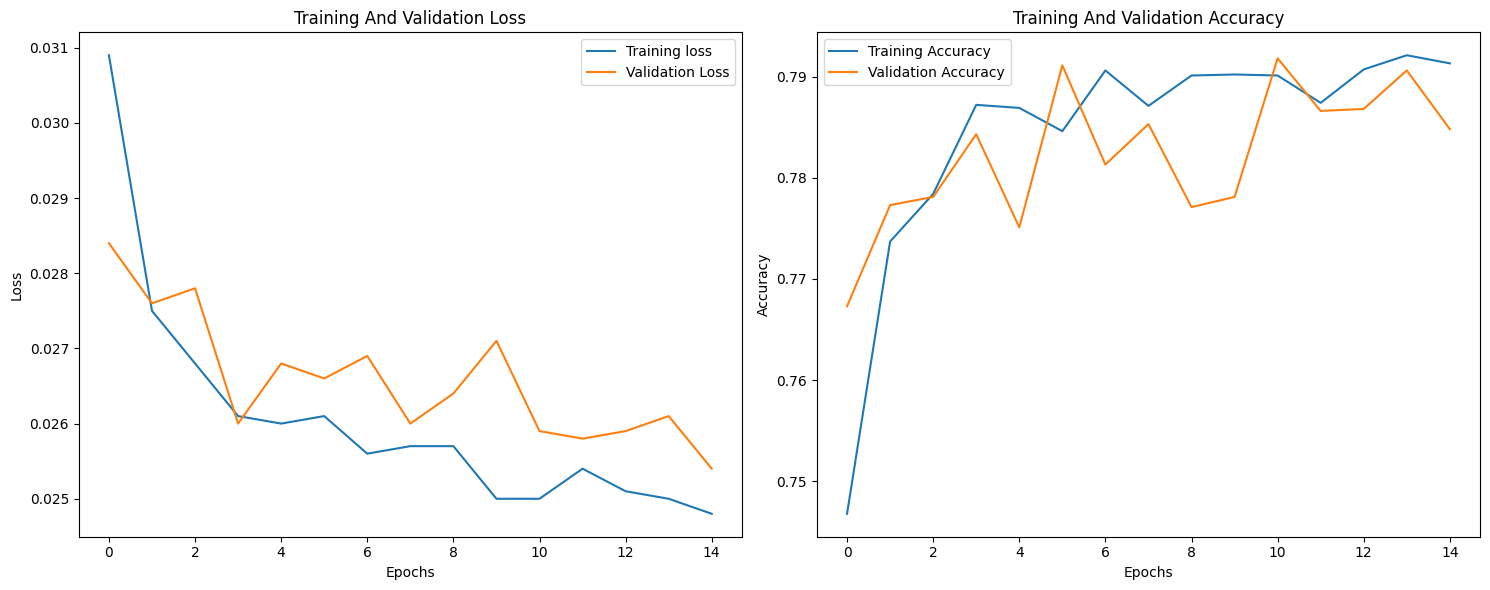

In [53]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,6))

axs[0].plot(total_loss_train_plot,label='Training loss')
axs[0].plot(total_loss_val_plot,label='Validation Loss')
axs[0].set_title('Training And Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_val_plot,label='Validation Accuracy')
axs[1].set_title('Training And Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()